In [1]:
import sys
import csv
import os
sys.path.insert(0, '..')
import ecoscape_connectivity
from scgt import GeoTiff, Tile
import time
import torch
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available() else 
          torch.device('mps') if torch.backends.mps.is_available() else
          torch.device('cpu'))


In [ ]:
DATA_PATH="assets"

HABITAT_PATH = os.path.join(DATA_PATH, "habitat_CA.tif")
LANDCOVER_PATH = os.path.join(DATA_PATH, "terrain_CA.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "permeability_CA.csv")


In [ ]:
with open(PERMEABILITY_PATH, mode='r') as infile:
    reader = csv.reader(infile)
    permeability_dict = {rows[0]:rows[1] for rows in reader}

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "Outputs/connectivity_CA.tif")
FLOW_PATH = os.path.join(DATA_PATH, "Outputs/flow_CA.tif")


## Version v3

New


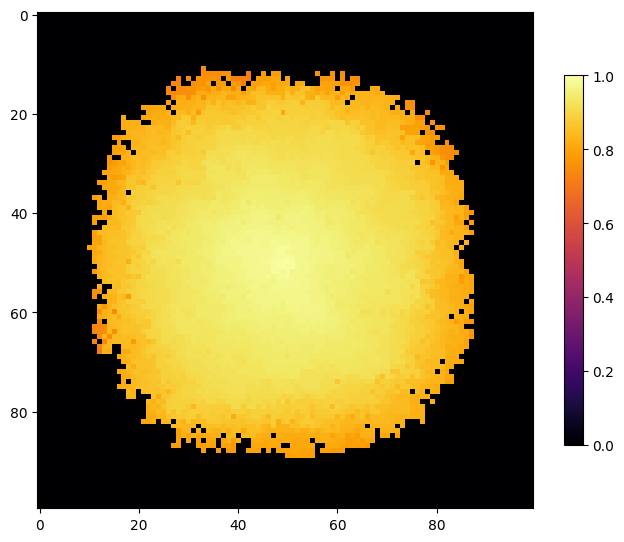

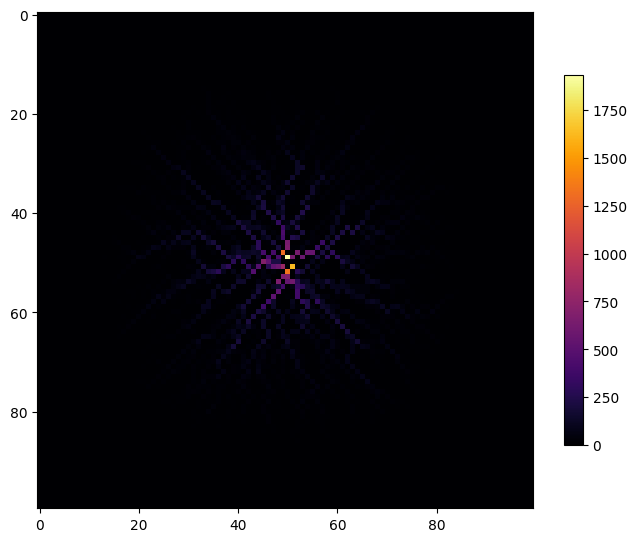

In [6]:

hab = torch.ones((100, 100), device=device)
ter = torch.ones((100, 100), device=device)
repopulator = ecoscape_connectivity.RandomPropagate_v3(
    hab, ter, 
    num_spreads=40, 
    spread_size=1, device=device).to(device)
seeds = torch.zeros((100, 100))
seeds[50, 50] = 1
seeds = seeds.to(device)
pop = repopulator(seeds)
a = pop.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(a, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()
tot_pop = pop.sum()
tot_pop.backward()
flow = repopulator.get_grad()
flow = flow.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(flow, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()


Single tile
New
Time: 125.94285535812378
(1, 189, 233)


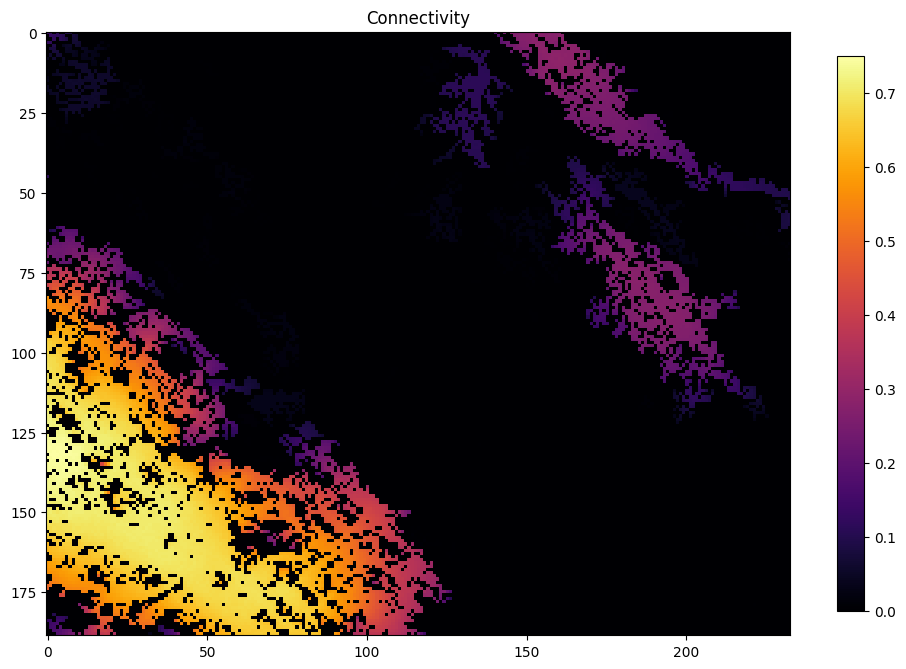

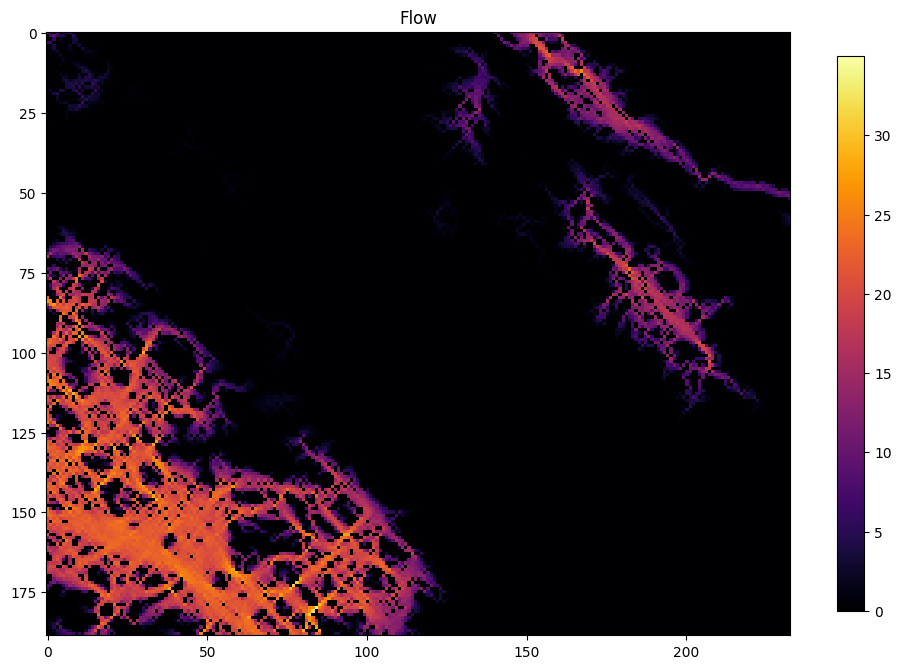

In [8]:
t0 = time.time()
ecoscape_connectivity.compute_connectivity_v3(
    habitat_fn=HABITAT_PATH,
    landcover_fn=LANDCOVER_PATH,
    permeability_dict=permeability_dict,
    connectivity_fn=CONNECTIVITY_PATH,
    flow_fn=FLOW_PATH,
    single_tile=True,
    border_size=50,
    num_simulations=2000,
    include_border=False,
    dispersal=50, # ecoscape_connectivity.half_cauchy(10, 40),
)
print("Time:", time.time() - t0)
single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
t = single_connectivity.get_all_as_tile(b=0)
print(t.m.shape)
t.draw_tile(width=12, height=12, title="Connectivity")
single_flow = GeoTiff.from_file(FLOW_PATH)
t = single_flow.get_all_as_tile(b=0)
t.draw_tile(width=12, height=12, title="Flow")

## Version v2

New


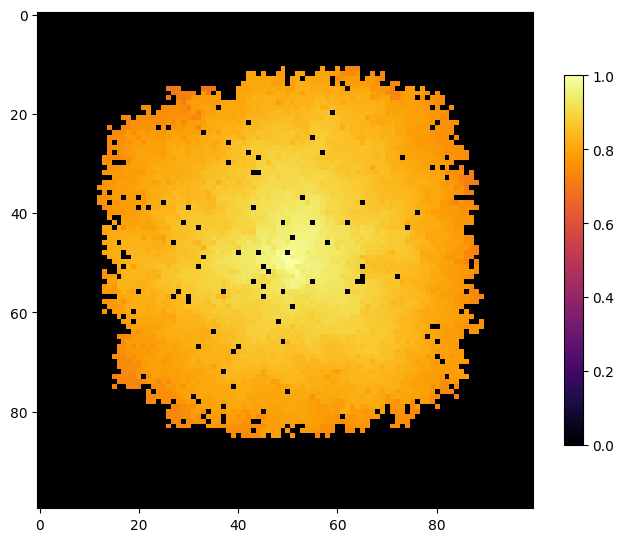

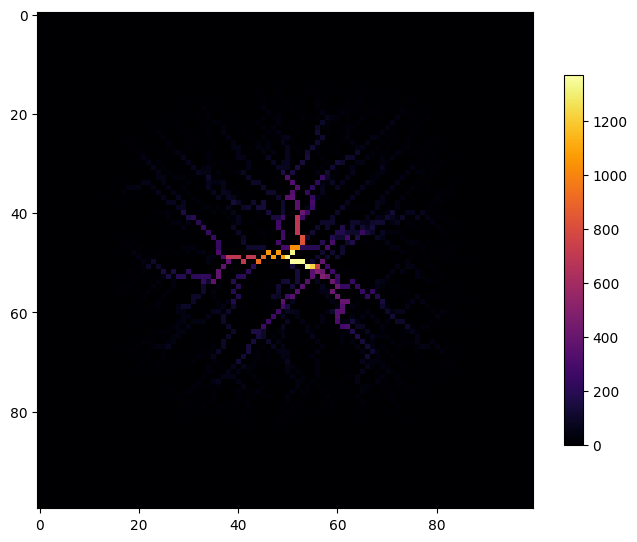

In [9]:

hab = torch.ones((100, 100), device=device)
ter = torch.ones((100, 100), device=device)
repopulator = ecoscape_connectivity.RandomPropagate_v2(
    hab, ter, 
    num_spreads=40, 
    spread_size=1, device=device).to(device)
seeds = torch.zeros((100, 100))
seeds[50, 50] = 1
seeds = seeds.to(device)
pop = repopulator(seeds)
a = pop.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(a, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()
tot_pop = pop.sum()
tot_pop.backward()
flow = repopulator.get_grad()
flow = flow.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(flow, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()


Single tile
New
Time: 104.90367102622986
(1, 189, 233)


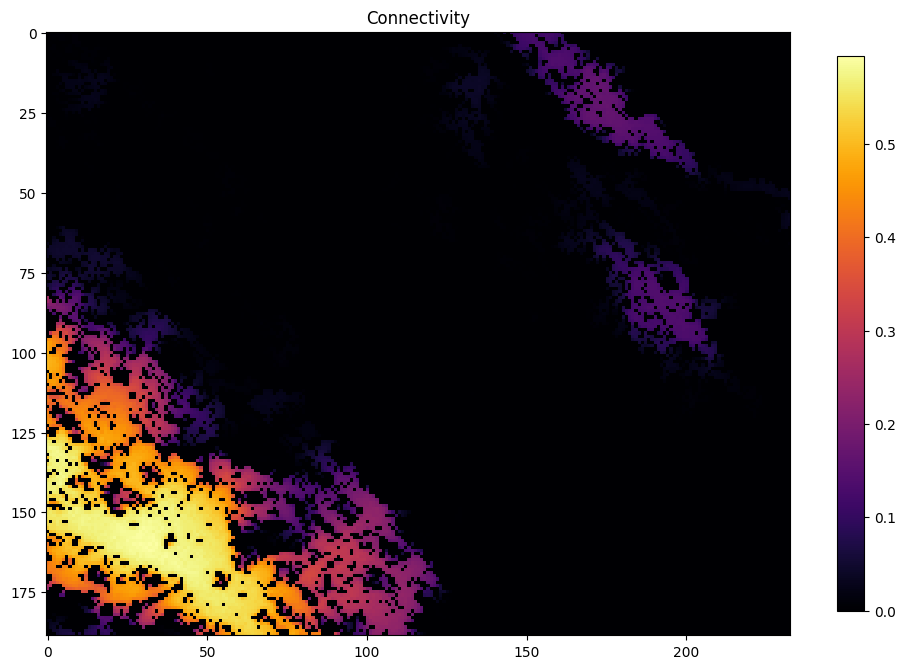

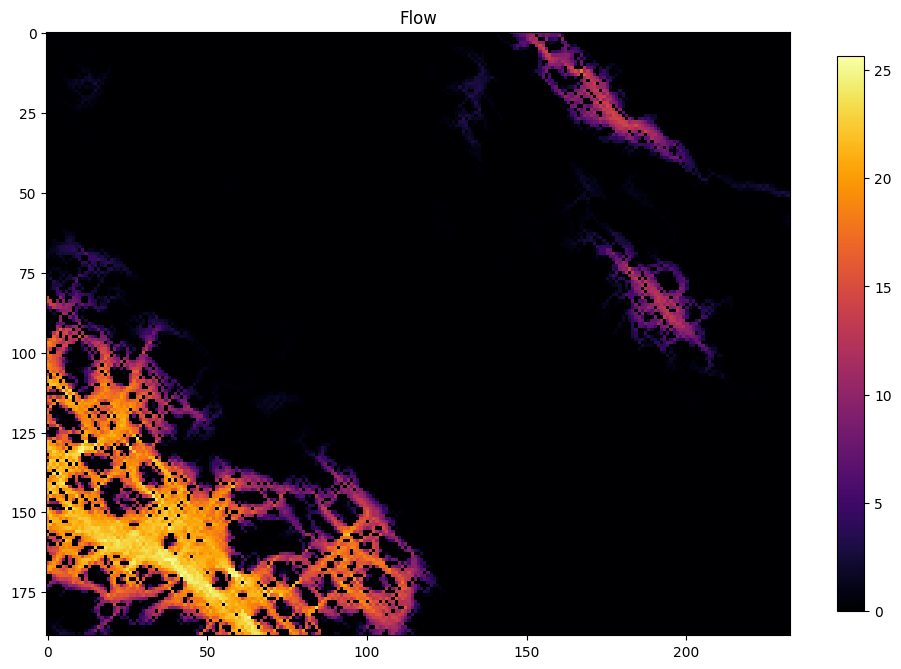

In [10]:
t0 = time.time()
ecoscape_connectivity.compute_connectivity_v2(
    habitat_fn=HABITAT_PATH,
    landcover_fn=LANDCOVER_PATH,
    permeability_dict=permeability_dict,
    connectivity_fn=CONNECTIVITY_PATH,
    flow_fn=FLOW_PATH,
    single_tile=True,
    border_size=50,
    num_simulations=2000,
    include_border=False,
    dispersal=50, # ecoscape_connectivity.half_cauchy(10, 40),
)
print("Time:", time.time() - t0)
single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
t = single_connectivity.get_all_as_tile(b=0)
print(t.m.shape)
t.draw_tile(width=12, height=12, title="Connectivity")
single_flow = GeoTiff.from_file(FLOW_PATH)
t = single_flow.get_all_as_tile(b=0)
t.draw_tile(width=12, height=12, title="Flow")

## Version v

New


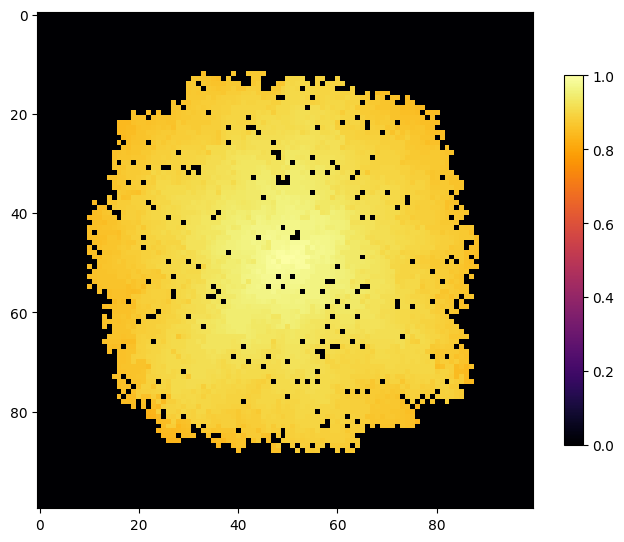

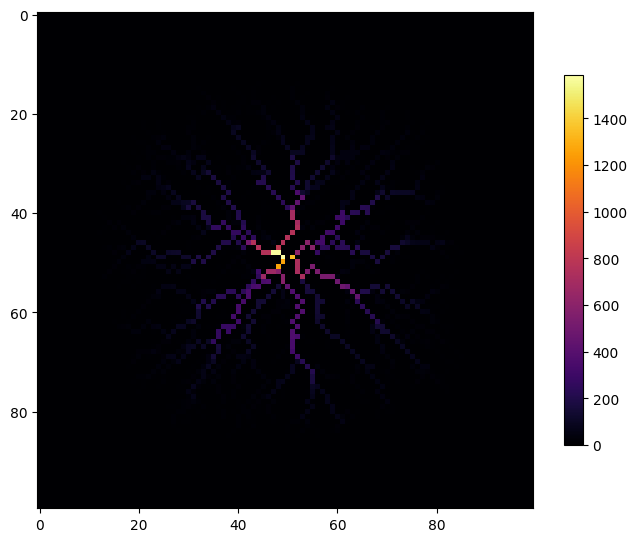

In [6]:

hab = torch.ones((100, 100), device=device)
ter = torch.ones((100, 100), device=device)
repopulator = ecoscape_connectivity.RandomPropagate_v(
    hab, ter, 
    num_spreads=40, 
    spread_size=1, device=device).to(device)
seeds = torch.zeros((100, 100))
seeds[50, 50] = 1
seeds = seeds.to(device)
pop = repopulator(seeds)
a = pop.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(a, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()
tot_pop = pop.sum()
tot_pop.backward()
flow = repopulator.get_grad()
flow = flow.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(flow, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()


Single tile
New
Time: 164.5379409790039
(1, 189, 233)


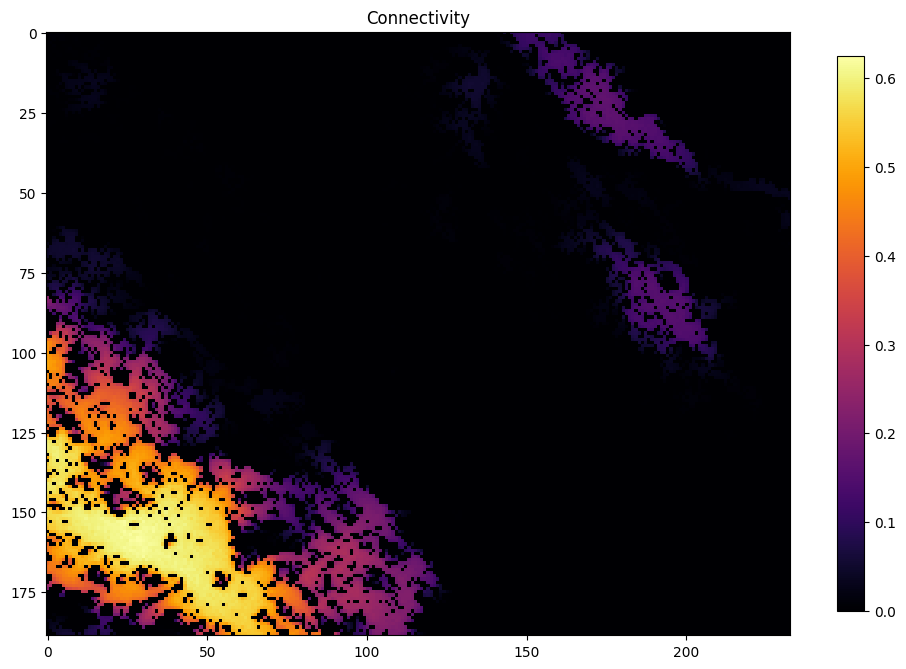

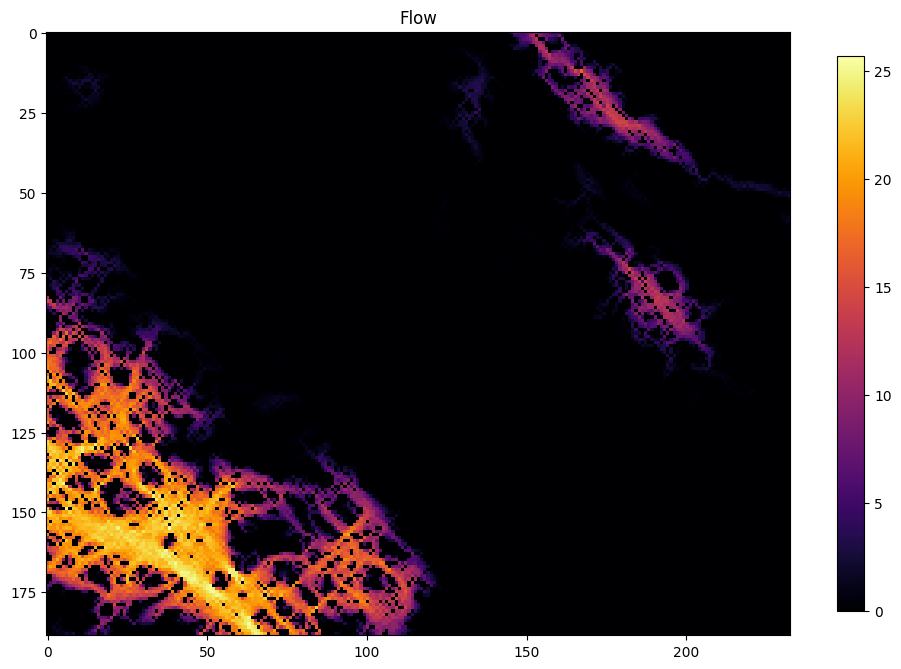

In [8]:
t0 = time.time()
ecoscape_connectivity.compute_connectivity_v(
    habitat_fn=HABITAT_PATH,
    landcover_fn=LANDCOVER_PATH,
    permeability_dict=permeability_dict,
    connectivity_fn=CONNECTIVITY_PATH,
    flow_fn=FLOW_PATH,
    single_tile=True,
    border_size=50,
    num_simulations=2000,
    include_border=False,
    dispersal=50, # ecoscape_connectivity.half_cauchy(10, 40),
)
print("Time:", time.time() - t0)
single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
t = single_connectivity.get_all_as_tile(b=0)
print(t.m.shape)
t.draw_tile(width=12, height=12, title="Connectivity")
single_flow = GeoTiff.from_file(FLOW_PATH)
t = single_flow.get_all_as_tile(b=0)
t.draw_tile(width=12, height=12, title="Flow")

## Version 9

New_9


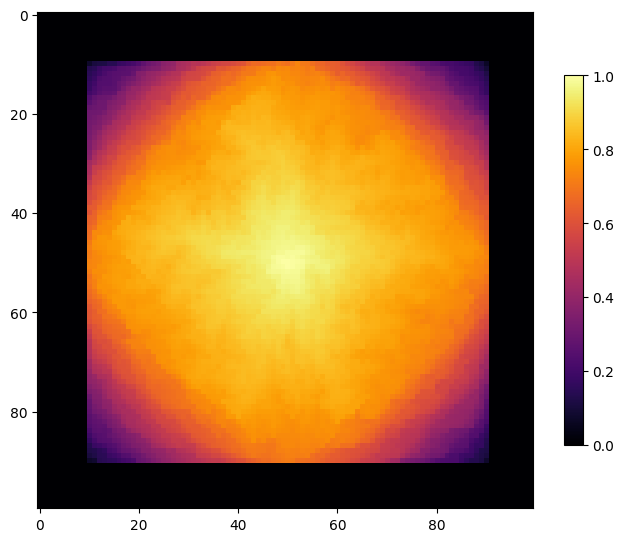

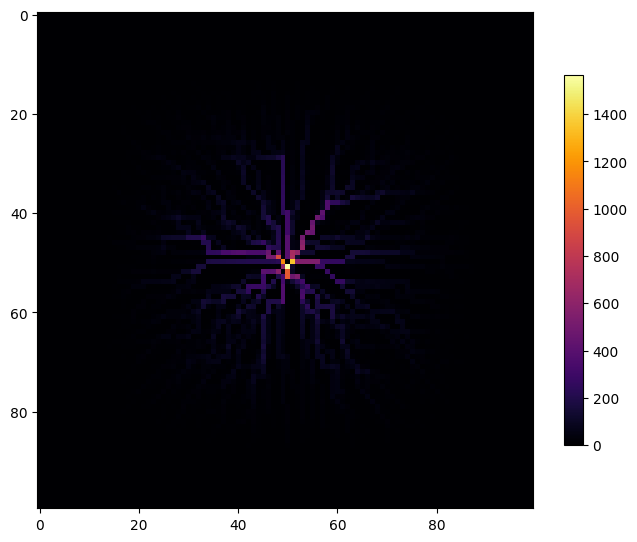

In [6]:

hab = torch.ones((100, 100), device=device)
ter = torch.ones((100, 100), device=device)
repopulator = ecoscape_connectivity.RandomPropagate_9(
    hab, ter, 
    num_spreads=40, 
    spread_size=1, device=device).to(device)
seeds = torch.zeros((100, 100))
seeds[50, 50] = 1
seeds = seeds.to(device)
pop = repopulator(seeds)
a = pop.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(a, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()
tot_pop = pop.sum()
tot_pop.backward()
flow = repopulator.get_grad()
flow = flow.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(flow, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()


Single tile
New_9
Time: 497.98084688186646
(1, 189, 233)


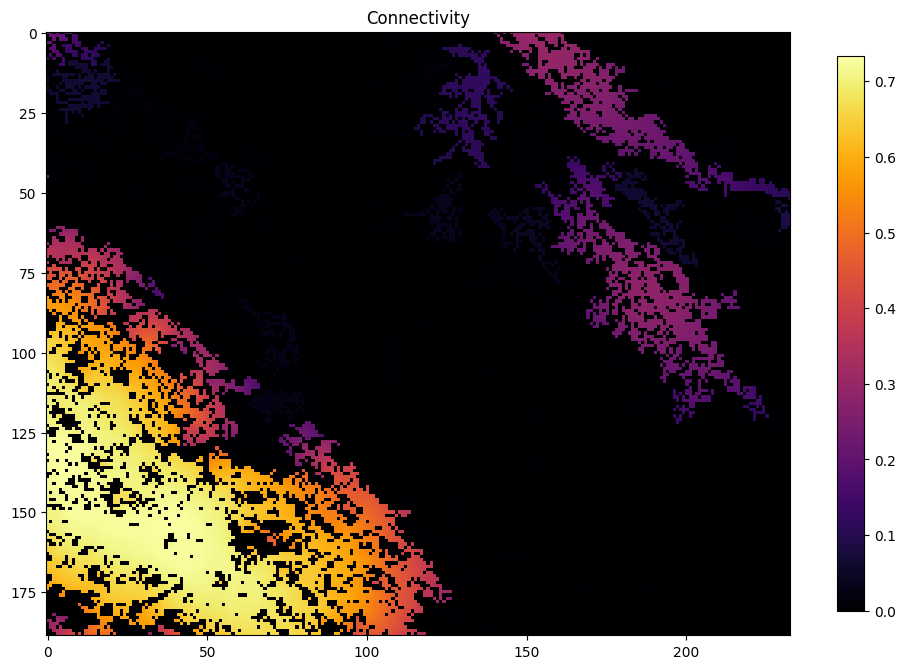

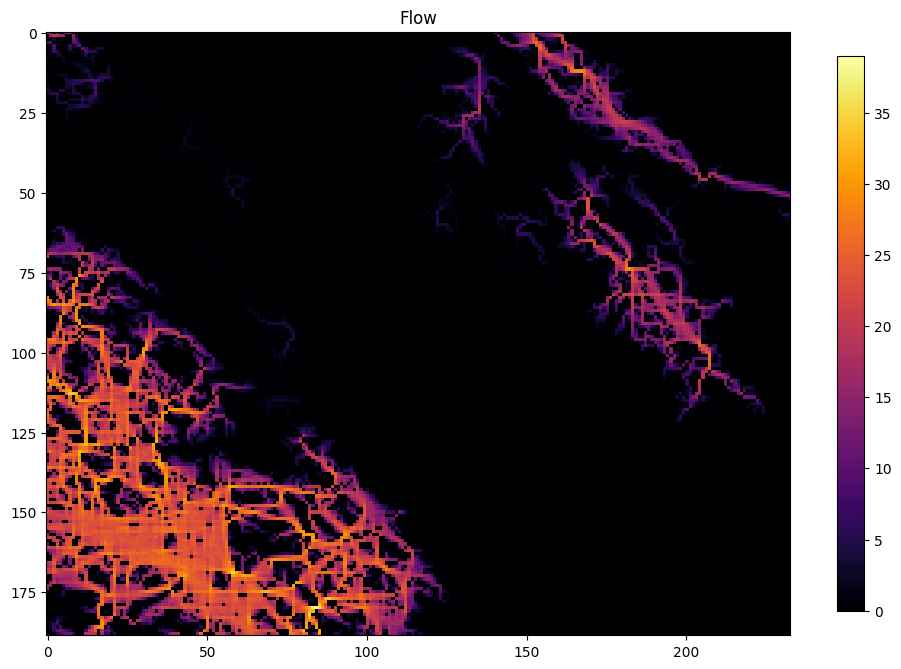

In [20]:
t = time.time()
ecoscape_connectivity.compute_connectivity_9(
    habitat_fn=HABITAT_PATH,
    landcover_fn=LANDCOVER_PATH,
    permeability_dict=permeability_dict,
    connectivity_fn=CONNECTIVITY_PATH,
    flow_fn=FLOW_PATH,
    single_tile=True,
    border_size=50,
    num_simulations=1000,
    include_border=False,
    dispersal=50, # ecoscape_connectivity.half_cauchy(10, 40),
)
print("Time:", time.time() - t)
single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
t = single_connectivity.get_all_as_tile(b=0)
print(t.m.shape)
t.draw_tile(width=12, height=12, title="Connectivity")
single_flow = GeoTiff.from_file(FLOW_PATH)
t = single_flow.get_all_as_tile(b=0)
t.draw_tile(width=12, height=12, title="Flow")

## Version comparison

In [19]:
from IPython.display import display, Markdown
algos = ["compute_connectivity_orig", "compute_connectivity_v2", "compute_connectivity_v3"]
titles = {
    "compute_connectivity_orig": "Original",
    "compute_connectivity_v2": "Single coin flip",
    "compute_connectivity_v3": "Two coin flips",
}

for algo in algos:
    display(Markdown(f"## {titles[algo]}"))
    t0 = time.time()
    alg = getattr(ecoscape_connectivity, algo)
    alg(
        habitat_fn=HABITAT_PATH,
        landcover_fn=LANDCOVER_PATH,
        permeability_dict=permeability_dict,
        connectivity_fn=CONNECTIVITY_PATH,
        flow_fn=FLOW_PATH,
        single_tile=True,
        border_size=50,
        num_simulations=2000,
        include_border=False,
        dispersal=50,
    )
    print("Time:", time.time() - t0)
    single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title=f"Connectivity {titles[algo]}")
    single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title=f"Flow {titles[algo]}")

## Original

Single tile
New


KeyboardInterrupt: 